In [78]:
import numpy as np
import pandas as pd
import faiss
import librosa
import audioread
import matplotlib.pyplot as plt
import os

In [79]:
df_30s=pd.read_csv("features_30_sec.csv")
df_30s.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [80]:
genres=df_30s["label"].unique()
genres

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [81]:
dir_path=r"C:\Users\kowsh\OneDrive\Documents\MSBA Coursework\Advanced ML by Prof Ghosh\Project\Data"

audio={}

for genre in genres:
    audio[genre] = [file for file in os.listdir(f'{dir_path}/genres_original/{genre}') if file.endswith('.wav')]


In [82]:
import pandas as pd
sound_df = pd.DataFrame(columns=['Genre', 'Filename', 'AudioData','SampleRate'])

for genre, file in audio.items():
    for idx, val in enumerate(file):
        try:
            data, sr = librosa.load(f'{dir_path}/genres_original/{genre}/{file[idx]}', sr=None)
            sound_df.loc[len(sound_df)] = {'Genre': genre, 'Filename': val, 'AudioData': data,'SampleRate':sr}
        except audioread.NoBackendError:
            print(f"Skipping {file[idx]} in {genre} due to audio I/O issue")
            continue


C:\Users\kowsh\AppData\Local\Temp\ipykernel_27120\3982184726.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(f'{dir_path}/genres_original/{genre}/{file[idx]}', sr=None)
c:\Users\kowsh\anaconda3\envs\DatasScienceProgrammingwithPy\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping jazz.00054.wav in jazz due to audio I/O issue


In [83]:
sound_df

,Genre,Filename,AudioData,SampleRate
0,blues,blues.00000.wav,"[0.0073242188, 0.016601562, 0.0076293945, -0.0...",22050
1,blues,blues.00001.wav,"[0.0034179688, 0.0043029785, 0.001373291, 0.00...",22050
2,blues,blues.00002.wav,"[0.019012451, 0.047698975, 0.029418945, -0.018...",22050
3,blues,blues.00003.wav,"[-0.013000488, -0.03060913, -0.036071777, -0.0...",22050
4,blues,blues.00004.wav,"[-0.0063171387, -0.009277344, -0.008331299, -0...",22050
...,...,...,...,...
994,rock,rock.00095.wav,"[-0.0826416, -0.12426758, -0.09277344, -0.0747...",22050
995,rock,rock.00096.wav,"[0.07272339, 0.10369873, 0.10211182, 0.1071167...",22050
996,rock,rock.00097.wav,"[-0.03414917, -0.038360596, 0.0030822754, 0.02...",22050
997,rock,rock.00098.wav,"[0.0859375, 0.14483643, 0.14294434, 0.1555481,...",22050


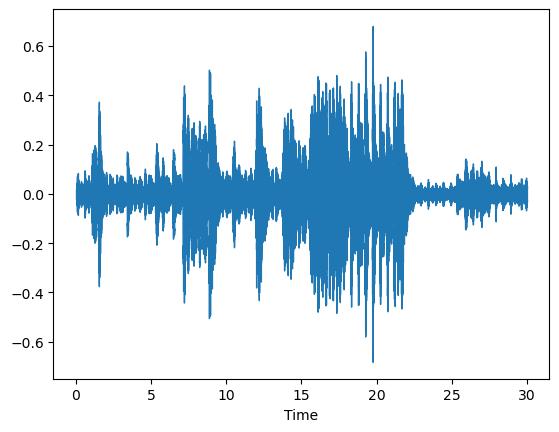

In [84]:
librosa.display.waveshow(sound_df.iloc[500,2])

In [85]:
n_fft=2048
hop_length=512
n_mels=128

mel_df = pd.DataFrame(columns=['Genre', 'Filename', 'Spectogram','MelSpectogram'])

# image_folder='images'
# os.makedirs(image_folder,exist_ok=True)

for idx,row in sound_df.iterrows():
    genre=row["Genre"]
    filename=row["Filename"]
    data=row["AudioData"]
    sr=row["SampleRate"]

    spec=librosa.stft(y=data)
    spec_db=librosa.amplitude_to_db(abs(spec))

    mel = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_db=librosa.power_to_db(mel)
    # plt.figure()
    # librosa.display.specshow(mel_db,sr=sr,x_axis='time',y_axis='mel',cmap='plasma')
    # plt.colorbar()


    # genre_folder = os.path.join(image_folder, genre)
    # os.makedirs(genre_folder, exist_ok=True)
    
    # image_filename = os.path.join(genre_folder, f'{filename.split(".wav")[0]}.png')
    # plt.savefig(image_filename)
    # plt.close()

    mel_df.loc[len(mel_df)]={"Genre":genre,"Filename":filename,"Spectogram":spec_db,"MelSpectogram":mel_db}

In [86]:
mel_df

,Genre,Filename,Spectogram,MelSpectogram
0,blues,blues.00000.wav,"[[8.420304, 8.523092, 8.084995, 9.497287, 10.0...","[[0.28048742, 1.3794851, -1.2811434, -5.179385..."
1,blues,blues.00001.wav,"[[-25.384867, 9.008634, 17.735878, 19.888996, ...","[[-2.581104, 2.7619686, 12.938466, 16.318106, ..."
2,blues,blues.00002.wav,"[[6.6919827, 3.3099804, -17.615246, -34.166374...","[[-2.1535807, -4.6150136, -8.026413, -7.485435..."
3,blues,blues.00003.wav,"[[11.746651, 6.0471764, -23.957638, -19.064632...","[[6.6351852, 3.3616076, -2.918642, -5.063306, ..."
4,blues,blues.00004.wav,"[[-24.572573, -12.845855, -6.4286633, -22.9971...","[[-25.82917, -22.386148, -20.946518, -18.81349..."
...,...,...,...,...
994,rock,rock.00095.wav,"[[4.7641616, -0.5846448, -27.841253, -44.93343...","[[-5.5859165, -11.27769, -25.715544, -25.56313..."
995,rock,rock.00096.wav,"[[5.455472, -1.9970834, -21.032202, -22.951975...","[[-3.528589, -10.760103, -17.871407, -17.33265..."
996,rock,rock.00097.wav,"[[-5.815454, -12.352266, -42.60322, -26.479406...","[[-15.863318, -16.814402, -14.205423, -11.0902..."
997,rock,rock.00098.wav,"[[-1.782944, -8.040599, -33.98976, -30.757393,...","[[-4.519562, 4.2569814, 7.367029, 4.6355, -5.6..."


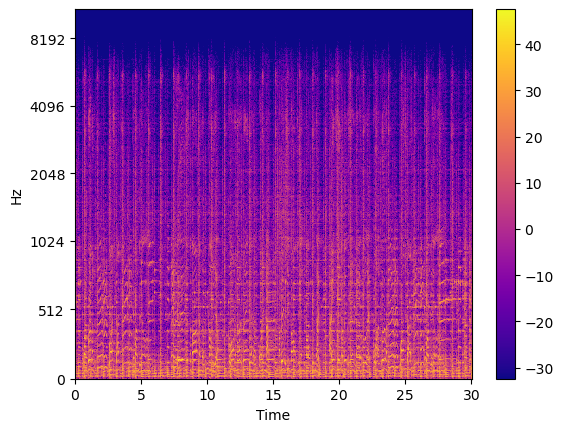

In [87]:
librosa.display.specshow(mel_df.iloc[0,2],sr=sound_df.iloc[0,3],x_axis='time',y_axis="mel",cmap='plasma')
plt.colorbar()

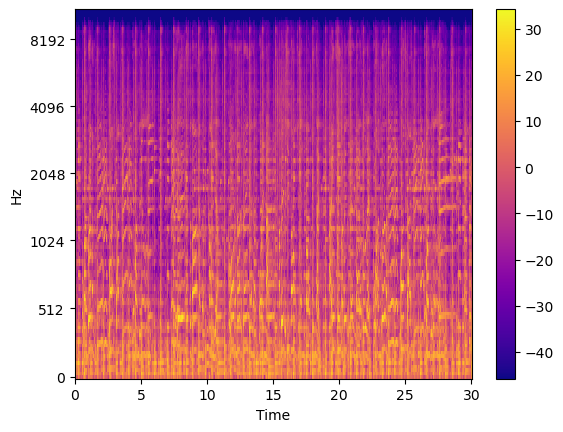

In [88]:
librosa.display.specshow(mel_df.iloc[0,3],sr=sound_df.iloc[0,3],x_axis='time',y_axis="mel",cmap='plasma')
plt.colorbar()

In [89]:
from sklearn.model_selection import train_test_split
X=df_30s.drop(["filename","label"],axis=1)
y=df_30s["label"]

In [90]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
y_dc=LabelEncoder().fit_transform(y)
X_dc=StandardScaler().fit_transform(X)

In [91]:
X_train1, X_test1,y_train1,y_test1=train_test_split(X_dc,y_dc,test_size=0.2,random_state=42,stratify=y_dc)

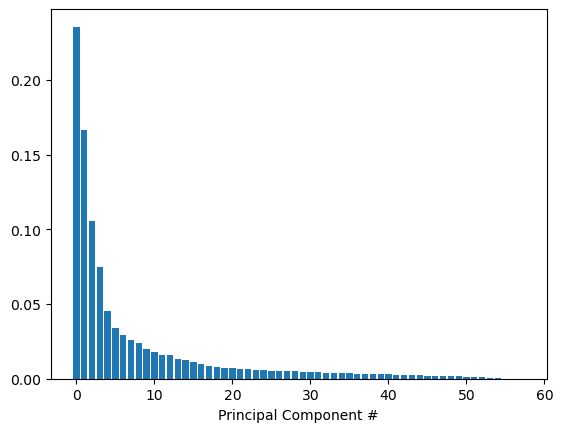

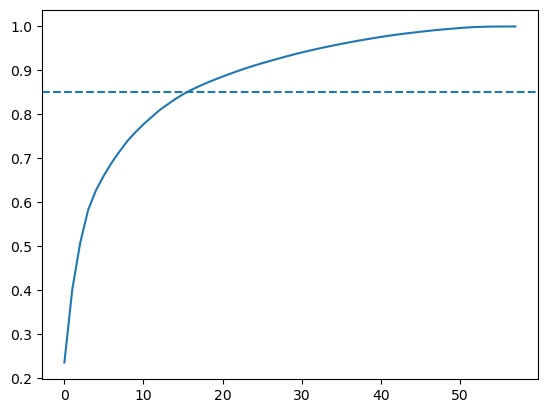

In [92]:
from sklearn.decomposition import PCA

pca = PCA(random_state=17).fit(X_dc)
exp_variance = pca.explained_variance_ratio_


fig, ax = plt.subplots()
ax.bar(range(len(exp_variance)), exp_variance)
ax.set_xlabel('Principal Component #')

import numpy as np

cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [93]:

pca = PCA(n_components=17,random_state=17) 

train_pca = pca.fit_transform(X_train1)
 
test_pca = pca.transform(X_test1)

### **KNN**

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': range(1, 100)}


grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid_search.fit(train_pca, y_train1)


best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}\n")


best_knn = grid_search.best_estimator_


y_pred = best_knn.predict(test_pca)

print(classification_report(y_test1, y_pred))
print(f'Test Accuracy: {accuracy_score(y_test1, y_pred) * 100}%')

knn_cfmat= confusion_matrix(y_test1,y_pred,normalize='true')


Best k value: 4

              precision    recall  f1-score   support

           0       0.67      0.70      0.68        20
           1       0.83      0.95      0.88        20
           2       0.55      0.80      0.65        20
           3       0.56      0.45      0.50        20
           4       0.83      0.75      0.79        20
           5       0.93      0.65      0.76        20
           6       0.81      0.65      0.72        20
           7       0.74      0.85      0.79        20
           8       0.61      0.55      0.58        20
           9       0.45      0.50      0.48        20

    accuracy                           0.69       200
   macro avg       0.70      0.68      0.68       200
weighted avg       0.70      0.69      0.68       200

Test Accuracy: 68.5%


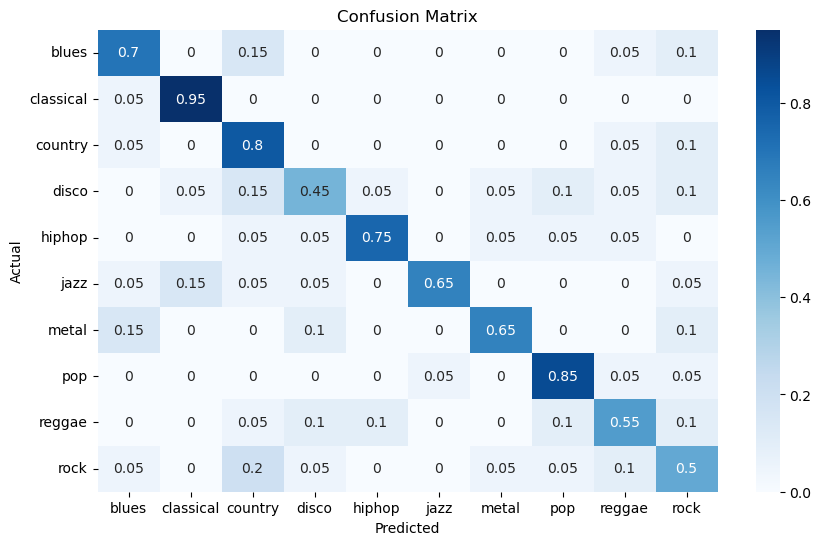

In [95]:
import seaborn as sns
knn_cfmat=np.round(knn_cfmat,2)
plt.figure(figsize=(10,6))
sns.heatmap(knn_cfmat, annot=True, cmap='Blues', xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [99]:
from sklearn.model_selection import KFold
import faiss
from collections import defaultdict
fold=KFold(n_splits=10)

k_neighbors=range(1,100)

k_scores={k:[] for k in k_neighbors}
for k in k_neighbors:
    acc=[]
    for train_idx, val_idx in fold.split(train_pca):
        X_train,y_train = X_train1[train_idx],y_train1[train_idx]
        X_val,y_val=X_train1[val_idx],y_train1[val_idx]

        vector_dim=X_train.shape[1]
    
        index=faiss.IndexFlatL2(vector_dim)
        index.add(X_train)

        D,I = index.search(X_val,k)
        
        y_pred=[]
        for idx,list in enumerate(I):
            genre_probs=defaultdict(float)
            neighbor_genres = [y_train[indices] for indices in list]
            for genre in neighbor_genres:
                genre_probs[genre] += 1 / k
            y_pred.append(max(genre_probs, key=genre_probs.get))
        accuracy=accuracy_score(y_val,y_pred)
        acc.append(accuracy)
    k_scores[k] =round(np.mean(acc)*100,2)

best_k = max(k_scores, key=k_scores.get)
print("Best k =", best_k)

Best k = 3


In [101]:
k=best_k
vector_dim=train_pca.shape[1]
index=faiss.IndexFlatL2(vector_dim)
index.add(train_pca)

D_test,I_test=index.search(test_pca,k)
predicted_genres = []
for i, indices in enumerate(I_test):
    sample_neighbor_genres = [y_train1[idx] for idx in indices]  
    
    genre_probs = defaultdict(float)
    for genre in sample_neighbor_genres:
        genre_probs[genre] += 1 / k
        
    predicted_genres.append(max(genre_probs, key=genre_probs.get))
accuracy = round(accuracy_score(y_test1, predicted_genres)*100,2)
print(f"Test Accuracy from Faiss KNN: {accuracy}%")

faiss_cfmat= confusion_matrix(y_test1,predicted_genres,normalize='true')

Test Accuracy from Faiss KNN: 70.5%


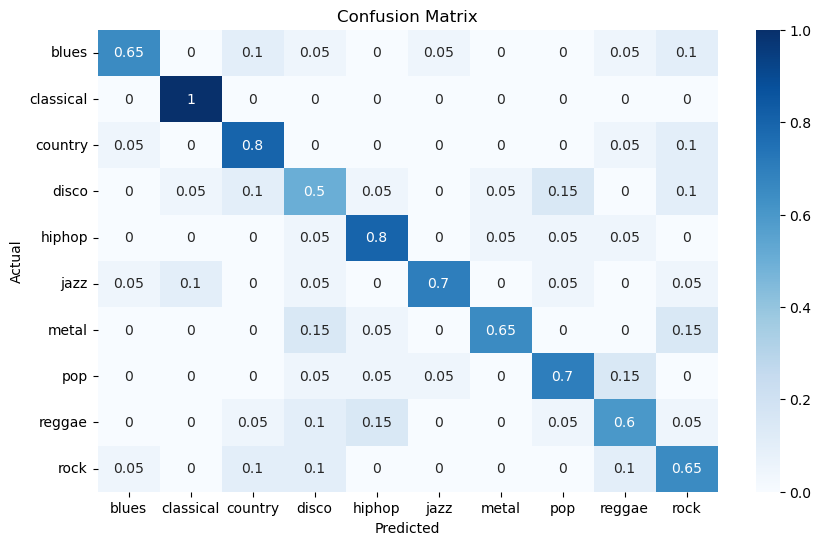

In [102]:
import seaborn as sns
faiss_cfmat=np.round(faiss_cfmat,2)
plt.figure(figsize=(10,6))
heatmap=sns.heatmap(faiss_cfmat, annot=True,cmap='Blues', xticklabels=genres, yticklabels=genres)
# cbar = heatmap.collections[0].colorbar
# cbar.set_ticks([0, 5, 10, 15])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()